## Capstone Two -- Black Friday Purchase Prediction

This notebook dives into a dataset that contains purchase information for black friday sales. The objective here is to import the data, ensure it is clean and tidy, explore it for any beneficial statistical relationships, perform pre-processing, and then finally create a model that accurately predicts the purchase price.

In [64]:
# Importing all necessary modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

#### Data Wrangling

In [65]:
# Importing train and test data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


The missing values in this dataset all occur in the Product_Category 2 and 3 columns. These values will be set to 0 for now. If it is found that the value needs to be changed, that can be done later.

In [67]:
# Checking shape of dataframe and filling all na values with 0
print(test.shape)
test.fillna(0, inplace=True)
test.head()

(233599, 11)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,0.0
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,0.0
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,0.0
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,0.0
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0


In [68]:
# Performing the same operations on the train set
print(train.shape)
train.fillna(0, inplace=True)
train.head()

(550068, 12)


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,0.0,0.0,7969


In [69]:
# Checking for any other issues in the dataframe
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          550068 non-null  float64
 10  Product_Category_3          550068 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [70]:
train.Product_Category_2 = train.Product_Category_2.astype('int64')
train.Product_Category_3 = train.Product_Category_3.astype('int64')

There are some object dtypes that need to be addressed before model fitting and training.

#### Exploratory Data Analysis

In [71]:
train.Purchase.describe()

count    550068.000000
mean       9263.968713
std        5023.065394
min          12.000000
25%        5823.000000
50%        8047.000000
75%       12054.000000
max       23961.000000
Name: Purchase, dtype: float64

In [72]:
train['Occupation'].value_counts()

4     72308
0     69638
7     59133
1     47426
17    40043
20    33562
12    31179
14    27309
2     26588
16    25371
6     20355
3     17650
10    12930
5     12177
15    12165
11    11586
19     8461
13     7728
18     6622
9      6291
8      1546
Name: Occupation, dtype: int64

In [73]:
train['Stay_In_Current_City_Years'].value_counts()

1     193821
2     101838
3      95285
4+     84726
0      74398
Name: Stay_In_Current_City_Years, dtype: int64

In [74]:
train['Stay_In_Current_City_Years'] = pd.to_numeric(train['Stay_In_Current_City_Years']\
                                                    .str.replace('+', ''))

In [75]:
train.Age.value_counts()

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

<AxesSubplot:>

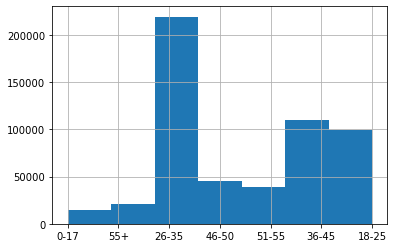

In [76]:
train.Age.hist(bins=7)

The average purchase price is around 9200. With a min of 12 and a max of 23900

In [77]:
# Removing the ID columns
train.drop(columns=['Product_ID', 'User_ID'], inplace=True)
test.drop(columns=['Product_ID', 'User_ID'], inplace=True)

array([[<AxesSubplot:title={'center':'Occupation'}>,
        <AxesSubplot:title={'center':'Stay_In_Current_City_Years'}>,
        <AxesSubplot:title={'center':'Marital_Status'}>],
       [<AxesSubplot:title={'center':'Product_Category_1'}>,
        <AxesSubplot:title={'center':'Product_Category_2'}>,
        <AxesSubplot:title={'center':'Product_Category_3'}>],
       [<AxesSubplot:title={'center':'Purchase'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

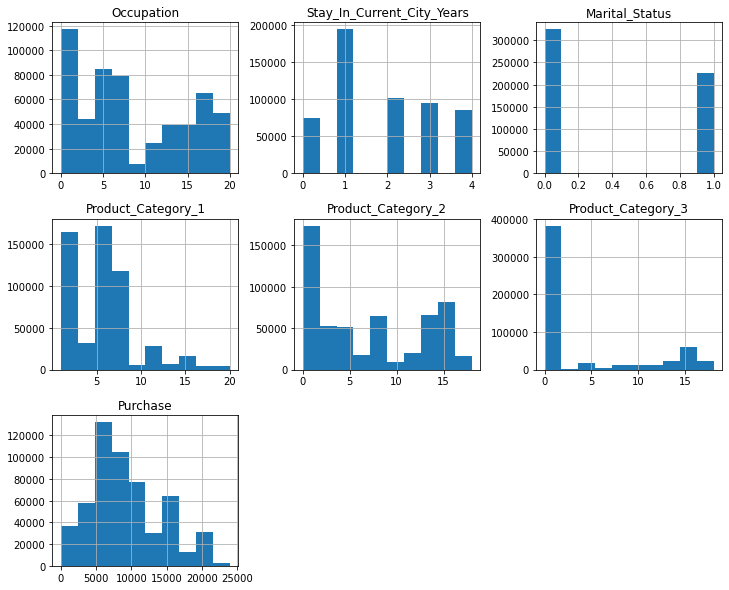

In [78]:
# Checking the distribution on applicable columns
train.hist(figsize=(12,10))

The Purchase column more closely resembles a normal(gaussian) distribution. This is good.

<AxesSubplot:xlabel='Age', ylabel='Purchase'>

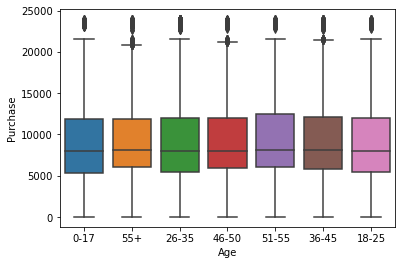

In [79]:
# Checking the distribution of purchase price per age group
sns.boxplot(x='Age', y='Purchase', data=train)

The purchase price is appears to be evenly distributed between all age groups

<AxesSubplot:xlabel='Marital_Status', ylabel='Purchase'>

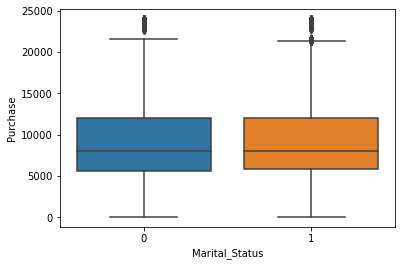

In [80]:
sns.boxplot(x='Marital_Status', y='Purchase', data=train)

Marital status seems to have no effect on purchase price

<AxesSubplot:xlabel='Gender', ylabel='Purchase'>

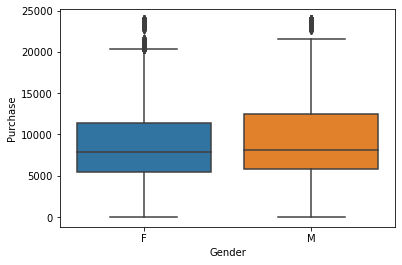

In [81]:
sns.boxplot(x='Gender', y='Purchase', data=train)

A simple observation shows that males spend slightly more than females. This could simply be a quirk of this particular dataset and not representative of the whole.

<AxesSubplot:xlabel='City_Category', ylabel='Purchase'>

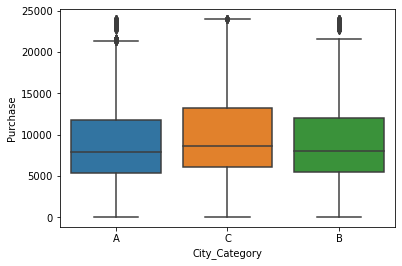

In [82]:
sns.boxplot(x='City_Category', y='Purchase', data=train)

City category C spends slightly more than the other two categories

In [83]:
train.columns

Index(['Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [84]:
# Making a list of categoricals to generate dummies from
categoricals = ['Gender', 'Age', 'Occupation', 'City_Category', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3']

In [85]:
# Checking remaining values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Gender                      550068 non-null  object
 1   Age                         550068 non-null  object
 2   Occupation                  550068 non-null  int64 
 3   City_Category               550068 non-null  object
 4   Stay_In_Current_City_Years  550068 non-null  int64 
 5   Marital_Status              550068 non-null  int64 
 6   Product_Category_1          550068 non-null  int64 
 7   Product_Category_2          550068 non-null  int64 
 8   Product_Category_3          550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 42.0+ MB


In [86]:
X = train[categoricals]
y = test[categoricals]

In [87]:
train_numeric = train.drop(columns=categoricals)
test_numeric = test.drop(columns=categoricals)

In [88]:
train_dummies = pd.get_dummies(X)
test_dummies = pd.get_dummies(y)

In [89]:
X = pd.concat([train_dummies, train_numeric], axis=1)
y = pd.concat([test_dummies, test_numeric], axis=1)

In [90]:
X.columns

Index(['Occupation', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Gender_F', 'Gender_M',
       'Age_0-17', 'Age_18-25', 'Age_26-35', 'Age_36-45', 'Age_46-50',
       'Age_51-55', 'Age_55+', 'City_Category_A', 'City_Category_B',
       'City_Category_C', 'Stay_In_Current_City_Years', 'Purchase'],
      dtype='object')

In [91]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype
---  ------                      --------------   -----
 0   Occupation                  550068 non-null  int64
 1   Marital_Status              550068 non-null  int64
 2   Product_Category_1          550068 non-null  int64
 3   Product_Category_2          550068 non-null  int64
 4   Product_Category_3          550068 non-null  int64
 5   Gender_F                    550068 non-null  uint8
 6   Gender_M                    550068 non-null  uint8
 7   Age_0-17                    550068 non-null  uint8
 8   Age_18-25                   550068 non-null  uint8
 9   Age_26-35                   550068 non-null  uint8
 10  Age_36-45                   550068 non-null  uint8
 11  Age_46-50                   550068 non-null  uint8
 12  Age_51-55                   550068 non-null  uint8
 13  Age_55+                     550068 non-null 

In [92]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233599 entries, 0 to 233598
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Occupation                  233599 non-null  int64  
 1   Marital_Status              233599 non-null  int64  
 2   Product_Category_1          233599 non-null  int64  
 3   Product_Category_2          233599 non-null  float64
 4   Product_Category_3          233599 non-null  float64
 5   Gender_F                    233599 non-null  uint8  
 6   Gender_M                    233599 non-null  uint8  
 7   Age_0-17                    233599 non-null  uint8  
 8   Age_18-25                   233599 non-null  uint8  
 9   Age_26-35                   233599 non-null  uint8  
 10  Age_36-45                   233599 non-null  uint8  
 11  Age_46-50                   233599 non-null  uint8  
 12  Age_51-55                   233599 non-null  uint8  
 13  Age_55+       